# Bayesian Change Point Detection

This notebook is an implementation of paper

__Ruggieri, E., 2013. A Bayesian approach to detecting change points in climatic records. International Journal of Climatology, 33(2), pp.520-528.__

In [1]:
using Distributions
using PyPlot

## Data generation
Example reproduced from Sec 3

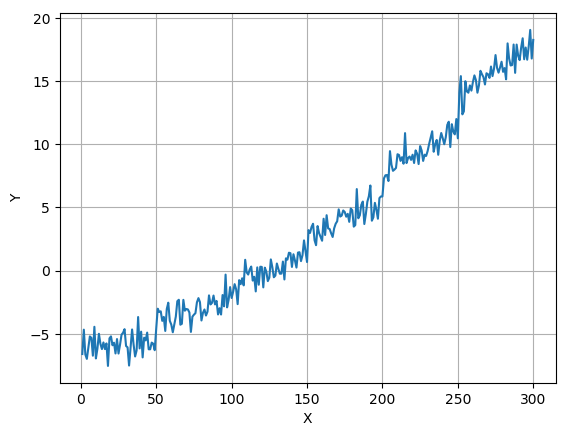

In [2]:
# N = 100
# k_max = 5
# d_min = 5
# β = [ rand( Uniform(-10.0,+10.0) ), rand( Uniform(-1.10,+1.10) ) ]
# # β = [ -6.25, 0.05 ]
# X = [ ones(N) collect( 1:N ) ]
# ϵ = Normal( 0.0, 2.0 )
# Y = X*β + rand( ϵ, N )
# β = [ rand( Uniform(-10.0,+10.0) ), rand( Uniform(-0.10,+0.10) ) ]
# Y[Int(N/2+1):end,:] = X[Int(N/2+1):end,:]*β + rand( ϵ, Int(N/2) )

nSeg    = 6;
tDist   = 50;
nStdDev = 0.75;
N = nSeg * tDist
k_max = 6
d_min = 40
X = [ ones(nSeg*tDist) collect(1:nSeg*tDist) ]
Y = zeros( nSeg*tDist, 1 )
Y[0*tDist+1:1*tDist,:] = X[0*tDist+1:1*tDist,:]*[ -6.25, 0.02 ] + nStdDev*randn(tDist,1)
Y[1*tDist+1:2*tDist,:] = X[1*tDist+1:2*tDist,:]*[ -6.25, 0.04 ] + nStdDev*randn(tDist,1)
Y[2*tDist+1:3*tDist,:] = X[2*tDist+1:3*tDist,:]*[ -6.25, 0.05 ] + nStdDev*randn(tDist,1)
Y[3*tDist+1:4*tDist,:] = X[3*tDist+1:4*tDist,:]*[ -6.25, 0.06 ] + nStdDev*randn(tDist,1)
Y[4*tDist+1:5*tDist,:] = X[4*tDist+1:5*tDist,:]*[ -6.25, 0.07 ] + nStdDev*randn(tDist,1)
Y[5*tDist+1:6*tDist,:] = X[5*tDist+1:6*tDist,:]*[ -6.25, 0.08 ] + nStdDev*randn(tDist,1)


plot( 1:size(X,1), Y )
xlabel( "X" ); ylabel( "Y" ); 
# title( @sprintf("\$Y = %3.2f + %3.2fX + \\epsilon\$",β[1],β[2]) )
grid();

## 1. Calculating the Probability density of data $P(Y_{i,j}|X)$
\begin{align}
f(Y_{i:j}) = \frac{1}{(2\pi)^{n/2}} \frac{k_0 ^{m/2}}{|X^TX+k_0 I|^{m/2}} \frac{(\nu_0 \sigma_0^2/2)^{\nu_0/2}}{(s_n/2)^{\nu_n/2}} \frac{\Gamma(\nu_n/2)}{\Gamma(\nu_0/2)}
\end{align}
Or in $log$ form
\begin{align}
f(Y_{i:j}) = - \frac{n}{2} \log{2 \pi} + \frac{m}{2} \log{k_0} - \frac{1}{2} \log{|X^TX+k_0 I|} + \frac{\nu_0}{2} \log{\frac{\nu_0 \sigma_0^2}{2}} - \frac{\nu_n}{2} \log{\frac{s_n}{2}} + \log \Gamma(\nu_n/2) - \log \Gamma(\nu_0/2)
\end{align}
for $1 \leq i < j \leq N$.

In [3]:
k₀ = 0.01
ν₀ = 1.00
σ₀²= 0.05

F = Vector{Vector{Float64}}()
for i = 1:N
# for i = 1:N-1
    Fᵢ = Vector{Float64}()
    for j = i+d_min-1:N
#     for j = i+1:N
        x = X[i:j,:]
        y = Y[i:j]
        n = length(y)
        m = size(X,2)
        βᵢⱼ =  (x'*x+k₀*I) \ (x'*y) # inv(x'*x+k₀) * x'*y
        νₙ = ν₀ + n
        sₙ = (y-x*βᵢⱼ)'*(y-x*βᵢⱼ) + k₀*βᵢⱼ'*βᵢⱼ + ν₀*σ₀²
        fᵢⱼ = ν₀/2*log(ν₀*σ₀²/2) + 
                lgamma(νₙ/2) + 
                    m/2*log(k₀) - 
                        lgamma(ν₀/2) -
                            νₙ/2*log(sₙ/2) -
                                n/2*log(2π)  -
                                    1/2*log(det(x'*x+k₀*I))
        push!( Fᵢ, fᵢⱼ )
    end
    push!( F, Fᵢ )
end

## 2. Forward Recursion
Let $P_k(Y_{i:j})$ be the density of data $[Y_1,\ldots,Y_j]$ with $k$ change points. Define ($f(Y_{i:j})$ are in linear scale)
\begin{align}
    P_1(Y_{1:j}) = \sum \limits_{v < j} f(Y_{1:v}) f(Y_{v+1:j})
\end{align}
and
\begin{align}
    P_k(Y_{1:j}) = \sum \limits_{v < j} P(Y_{1:v}) f(Y_{v+1:j})
\end{align}
$k < j \Leftarrow N$.

If $f(Y_{i:j})$ is in $log$ scale,
\begin{align}
    P_1(Y_{1:j}) = \log \left( \sum \limits_{v<j} \exp \left( f(Y_{1:v}) + f(Y_{v+1:j}) \right)\right)
\end{align}
and
\begin{align}
    P_k(Y_{1:j}) = \log \left( \sum \limits_{v<j} \exp \left( P(Y_{1:v}) + f(Y_{v+1:j}) \right)\right)
\end{align}

In [4]:
P = Vector{Vector{Float64}}()

P₁ = Vector{Float64}()
for j = 1+d_min+d_min-1:N
    Pᵢⱼ = 0.00
    for v = d_min:j-d_min
        Pᵢⱼ += exp(F[1][v-d_min+1]+F[v+1][j-d_min-v+1])
    end
    push!( P₁, log(Pᵢⱼ) )
end
push!( P, P₁ )

for k = 2:k_max
    Pₖ = Vector{Float64}()
    for j = (k+1)*d_min:N
        Pᵢⱼ = 0.00
        for v = k*d_min:j-d_min
            Pᵢⱼ += exp( P[k-1][v-k*d_min+1]+F[v+1][j-d_min-v+1] )
        end
        push!( Pₖ, log(Pᵢⱼ) )
    end
    push!( P, Pₖ )
end


## 3. Stochastic Backtrace via Bayes Rule
Let 
- $f(K=k)$ be the prior distribution over number of change points
- $f(c_1,c_2,\ldots,c_k|K=k)$ be the prior distribution on the location of change points
Then
\begin{align}
    f(Y_{1:N}) = \sum \limits_{k=0}^{k_{max}} \sum \limits_{c_1,\ldots,c_k} f(Y_{1:N}|K=k,c_1,\ldots,c_k) \times f(K = k, c_1,\ldots,c_k)
\end{align}

Assuming $0.5$ probability for all change points ($f(K=0) = 0.50$) and uniform probability for other change points $(f(K=k) = \frac{1-0.5}{k_{max}})$ and all change point locations are also equally likely, we have
\begin{align}
    f(K=k,c_1,\ldots,c_k) = \frac{0.5}{k_{max} \cdot nCk}
\end{align}
Remember $k$ change points are possible only if there exists $(k+1)*d_{min}$ data points.

The posterior distribution of number of change points is given by
\begin{align}
    f(K=k|Y_{1:N}) = \frac{P_k(Y_{1:N}) f(K = k, c_1,\ldots,c_k)}{f(Y_{1:N})}
\end{align}

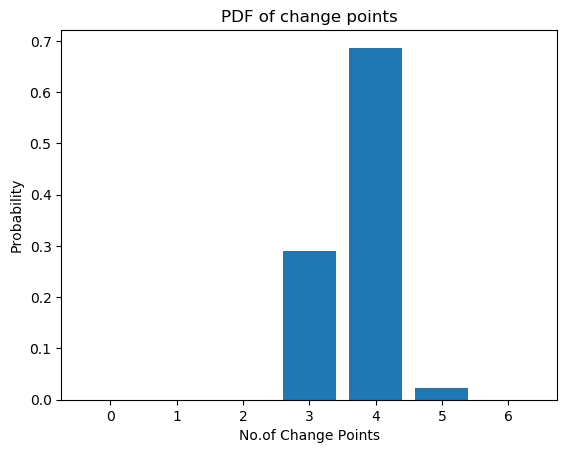

PyObject Text(0.5,1,'PDF of change points')

In [5]:
# Define custom function to handle large value
nCk(n,k) = prod(Float64(n-k+1):Float64(n))/factorial(k)

# Eqn. 5
fₖ = [ F[1][end]+log(0.5), [ P[k][end] + log(0.5/k_max) - log(nCk(N-(k+1)*d_min+k,k)) for k=1:k_max if (k+1)*d_min<=N ]; ]
fₖ = exp.(fₖ) / sum(exp.(fₖ));
        
# Plot the PDF for number of change points
bar( 0:k_max, fₖ ); xlabel( "No.of Change Points" ); ylabel( "Probability" ); title( "PDF of change points" )

#### 3.1 Sample a number of change points
Using Bayes rule, the posterior distribution of number of change points is given by
\begin{align}
    f(K=k|Y_{1:N}) = \frac{P_k(Y_{1:N}) f(K=k,c_1,\ldots,c_k)}{f(Y_{1:N})}
\end{align}
#### 3.2 Sample the location of the change points, $c_k$
For $k = K, K-1, \ldots, 1$, the posterior distribution on the location of change points is given by
\begin{align}
    f(c_k|c_{k+1}) = \frac{P_{k-1}(Y_{1:v})f(Y_{v+1:c_{k+1}})}{\sum \limits_{k \in [k-1,c_{k+1})} P_{k-1}(Y_{1:v})f(Y_{v+1:c_{k+1}})}.
\end{align}
When $k = 1$, $P_0(Y_{1:v}) = f(Y_{1:v})$.

#### 3.3 Sample the regression paramters for the interval between the change points

In [6]:
# Create a categorical distribution with f_k
Fₖ = Categorical( fₖ )

nSamples = 10000
m = size( X, 2 )
β = zeros( m, N )

sampLocVec = zeros( N )

for j = 1:nSamples
    # Sample the number of change points ( '0' is 1 )
    nChngPts = rand(Fₖ) - 1
    if nChngPts > 0     # If the sample has non-zero change points
        thisSegEnd = N
        for chngPts = nChngPts:-1:2
            locPVec = fill(-Inf,thisSegEnd-d_min+1);
            for l = chngPts*d_min:thisSegEnd-d_min
                locPVec[l] = P[chngPts-1][l-chngPts*d_min+1] + F[l+1][end-(N-thisSegEnd)]
            end
#             if( all(locPVec.==-Inf) )
#                 locPVec = fill( 1, thisSegEnd-d_min+1 )
#             end
            locDist = Categorical( exp.(locPVec)/sum(exp.(locPVec)) )
            samp_loc = rand( locDist )
            sampLocVec[samp_loc] += 1
            
            # Calculate regression parameters
            βᵢ = (X[samp_loc+1:thisSegEnd,:]'*X[samp_loc+1:thisSegEnd,:]+k₀*I) \ (X[samp_loc+1:thisSegEnd,:]'*Y[samp_loc+1:thisSegEnd,:])
            β[:,samp_loc+1:thisSegEnd] = β[:,samp_loc+1:thisSegEnd] .+ βᵢ
            
            thisSegEnd = samp_loc # This segment ends at samples location
        end
        
        # Final change point
        # Create a vector of locations to sample from
        locPVec = fill(-Inf,thisSegEnd-d_min+1)
        for l = d_min:thisSegEnd-d_min
            locPVec[l] = F[1][l-1*d_min+1] + F[l+1][end-(N-thisSegEnd)]
        end
        # Sample a location
#         if( all(locPVec.==-Inf) )
#             locPVec = fill( 1, thisSegEnd-d_min+1 )
#         end            
        locDist = Categorical(exp.(locPVec)/sum(exp.(locPVec)));
        samp_loc = rand( locDist )
        sampLocVec[samp_loc] += 1
        
        # Calculate regression parameters
        βᵢ = (X[samp_loc+1:thisSegEnd,:]'*X[samp_loc+1:thisSegEnd,:]+k₀*I) \ (X[samp_loc+1:thisSegEnd,:]'*Y[samp_loc+1:thisSegEnd,:])
        β[:,samp_loc+1:thisSegEnd] = β[:,samp_loc+1:thisSegEnd] .+ βᵢ
        
        # For the final segment
        βᵢ = (X[1:samp_loc,:]'*X[1:samp_loc,:]+k₀*I) \ (X[1:samp_loc,:]'*Y[1:samp_loc,:])
        β[:,1:samp_loc] = β[:,1:samp_loc] .+ βᵢ
        
    else
        println
        # Zero change points: Just calculate the regression parameter for whole data
        βᵢ = (X'*X+k₀*I) \ (X'*Y) # from i-th sample
        β = β .+ βᵢ
    end
end

sampLocVec ./= nSamples;
β ./= nSamples;

Y_hat = sum( X.*β', 2 );

### Plot Results

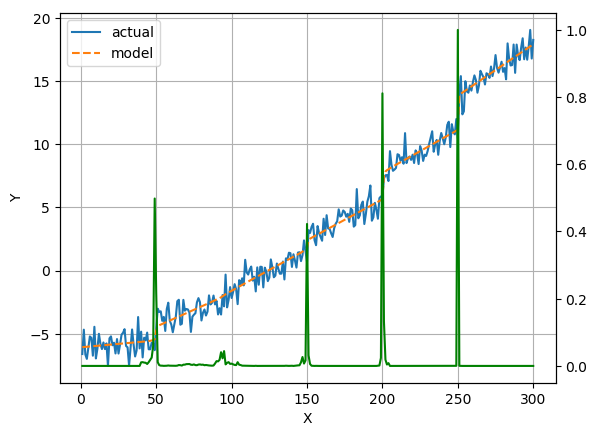

In [7]:
fig, ax1 = subplots();
ax1[:plot]( 1:size(X,1), Y, label = "actual" )
ax1[:plot]( 1:size(X,1), Y_hat, "--", label = "model" )
xlabel("X"); ylabel("Y");
grid(); legend();
ax2 = ax1[:twinx]()
ax2[:plot]( 1:N, sampLocVec, "g-" );
# xlabel( "X" ); ylabel( "Y" ); grid();

Calculate $R^2$ value as
\begin{align}
    R^2 = 1 - \frac{(Y-\hat{Y})^T(Y-\hat{Y})}{Y^T Y}
\end{align}

In [8]:
R² = 1 - sum((Y-Y_hat).^2)/sum(Y.^2)

0.9920695082074564